# About this notebook
In this example, we will walk through how to use CIDRE to detect anomalous journal groups in a citation network.  

We model an anomalous group to be composed of *donors* and *recipient*. A donor journal excessively cites many papers in other member journals. A recipient journal excessively receives many citations from the donor journals. 

A challenge---which we attempt to address with CIDRE---is that such anomalous groups are overshadowed by communities in citation networks. It is common that journals in the same fields cite with each other because they are related. Such communities are clearly not anomalous and we do not want to flag them as anomalous. 

We will demonstrate this issue and how we can tell CIDRE to take into account communities in ciation networks.

In [1]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre

In [2]:
# Data path
edge_file = "../data/journal-citation/edge-table-2013.csv"
node_file = "../data/journal-citation/community-label.csv"

In [3]:
# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

## About this network

This network is a citation network of journals in 2013 constructed from Microsoft Academic Graph. 
Each edge is weighted by the number of citations made to papers in prior two years.
The following are the basic stats of this network.

In [4]:
print("Number of nodes: %d" % A.shape[0])
print("Number of edges: %d" % A.sum())
print("Average degree: %.2f" % (A.sum()/A.shape[0]))
print("Max in-degree: %d" % np.max(A.sum(axis = 0)))
print("Max out-degree: %d" % np.max(A.sum(axis = 1)))
print("Maximum edge weight: %d" % A.max())
print("Minimum edge weight: %d" % np.min(A.data))

Number of nodes: 31385
Number of edges: 8038733
Average degree: 256.13
Max in-degree: 143633
Max out-degree: 228866
Maximum edge weight: 19792
Minimum edge weight: 1


## Communities overshadow anomalous groups.

Now, let us demonstrate how communities make it difficult to find anomalous groups. To this end, we run CIDRE without telling it about the communities in the network. 

In [5]:
# Group detection
# alpha: statistical significance level to find anomalous edges.
# min_edge_weight: the edges with weight less than this value will be removed prior to detecting groups.
alg = cidre.Cidre(group_membership = None, alpha = 0.01, min_edge_weight = 10)

groups = alg.detect(A, threshold=0.15)

Then, CIDRE detects super large group!

In [6]:
# group.size() will return the number of nodes in the group
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 6459
Number of groups detected: 80


This group consists of journals of related fields. Because they are frequently citing with each other, CIDRE detects them as an anomalous group. This problem---looking for anomalous group of densely connected nodes results in finding non-suspecious communities---can occur not only with CIDRE but also with other methods. It is, therefore, crutical to discount the effect of such dominant "normal" communities to find "anomalous" groups. 

## Finding anomalous groups in the network

It is straightforward to tell CIDRE the "normal" communities in the network. Determing what to be "normal" is your modelling decision. In context of the journal citation network, we consider journals in the same field as a normal citation community, and use a community detection algorithm (the degree-corrected stochastic block model) to identify the "normal" communities.

To tell the normal communities to CIDRE, pass the array of group memberships, `group_membership`, where `group_membership[i]` indicates the group to which node i belongs.

In [7]:
# Get group membership
node2com = dict(zip(node_table["journal_id"], node_table["community_id"]))
group_membership = [node2com[node_labels[i]] for i in range(A.shape[0])]

alg = cidre.Cidre(group_membership = group_membership, alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)

In [8]:
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 16
Number of groups detected: 129


## Visualizing anomalous groups

In [9]:
# group.get_num_edges() gives the total weight of edges within the group
groups_filtered = [group for group in groups if group.get_num_edges()>50] # Filter out the groups with total within-group edge weight less than 50
groups_sampled = [groups_filtered[i] for i in np.random.choice(len(groups_filtered), 3, replace = False)]

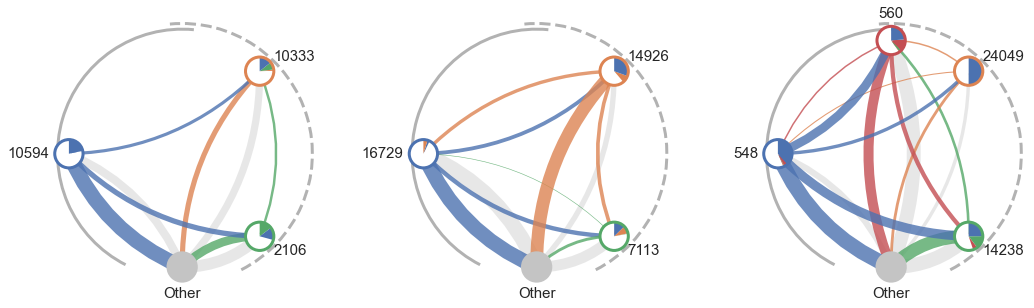

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(6 * 3, 5))

for i in range(3):
    cidre.DrawCartel().draw(groups_sampled[i], ax = axes.flat[i])

Let's place journal name instead of node IDs. To this end, we load node lables and make a dictionary from ID to label:

In [11]:
df = pd.read_csv("../data/journal-citation/journal_names.csv")
journalid2label = dict(zip(df.journal_id.values, df.name.values)) # MAG journal id -> Journal Name

id2label = {} # Dictionary from IDs to labels
for k, v in node_labels.items():
    id2label[k] = journalid2label[v]

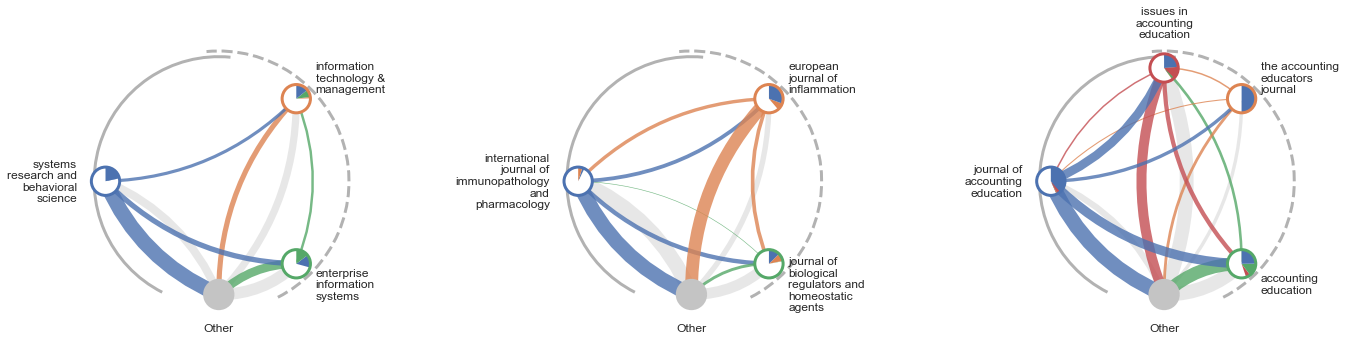

In [12]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(8 * 3, 5))

for i in range(3):
    plotter = cidre.DrawCartel()
    plotter.font_size = 12
    plotter.label_node_margin = 0.5
    plotter.draw(groups_sampled[i], node_labels = id2label, ax = axes.flat[i])